## 36. Модель роста с насыщением. Логистическая функция


Crombie A. C. On competition between different species of graminivorous insects. Proceedings of the Royal Society of London. Series B-Biological Sciences 132.869 (1945): 362–395. https://royalsocietypublishing.org/doi/pdf/10.1098/rspb.1945.0003

Ниже приведены данные о численности зернового точильщика (Rhyzopertha dominica) и зерновой моли (Sitotroga cerealella), разводимых (отдельно друг от друга) в 10-граммовой порции пшеничных 
зерен, пополняемых каждую неделю.

| Сутки |  Rhiz  | Sit  |              |
| ----- | ------ | ---- | ------------ |
|   0   |     2  |   0  |  (100 eggs)  |
|  14   |     2  |   0  |
|  28   |     2  |   5  |
|  35   |     3  |  15  |
|  42   |    17  |  51  |
|  49   |    65  |  59  |
|  56   |   NaN  |  15  |
|  63   |   119  |  58  |
|  77   |   130  | 185  |
|  84   |   NaN  | 114  |
|  91   |   175  |  68  |
| 105   |   205  | 151  |
| 119   |   261  | 200  |
| 133   |   302  | 130  |
| 147   |   330  | 206  |
| 161   |   315  | 178  |
| 175   |   333  | 110  |
| 189   |   350  | 180  |
| 203   |   332  | 120  |
| 231   |   333  | 200  |
| 245   |   335  | NaN  |
| 259   |   330  | NaN  |

`NaN` соответствуют пропущенным значениям.

Нелинейным методом наименьших квадратов по этим данным постройте функции вида (логистическую функцию)
$$
y = \frac{a}{1 + b e^{-ct}},
$$
предсказывающих количество особей $y$ по номеру суток $t$.

Обратите внимание на задание начальных значений для решения соответствующей задачи оптимизации и обработке пропущенных значений.

Изобразите данные и аппроксимирующие их функции.

Сравните ваше решение с найденным в цитируемой статье:
$$
{\rm Rhiz} = \frac{338}{1 + 87 e^{-0.05 t}},
\qquad
{\rm Sit} = \frac{200}{1 + 257 e^{-0.1 t}}.
$$
Постройте также графики и этих функций.

Существенны ли отличия? Дайте объяснение и сделайте выводы.

**Замечание.**
В статье также приводятся данные и анализируются о численности популяции суринамского мукоеда (Oryzaephilus surinamensis), а также данные по изменению численности этих популяций в конкурентной среде. При этом для анализа используется модель Вольтерра–Лотке.

### Решение

#### Подключение и инициализация необходимых библиотек

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, linalg

In [29]:
%matplotlib inline

#### Подготовительный этап

Для начала импортируем предоставленные данные - это можно делать по-разному: загружать их из файла (формата .csv или любого другого), либо прописать их вручную - для задачи, стоящей перед нами, можно обойтись вторым путём.

Значения каждого столбца определим в соотвествующий массив - `days` для суток, `rhiz` и `sit` для Rhiz и Sit соответственно.

In [30]:
x_days = np.array([0, 14, 28, 35, 42, 49, 56, 63, 77, 84, 91, 105, 119, 133, 147, 161, 175, 189, 203, 231, 245, 259])
y_rhiz = np.array([2, 2, 2, 3, 17, 65, np.nan, 119, 130, np.nan, 175, 205, 261, 302, 330, 315, 333, 350, 332, 333, 335, 330])
y_sit  = np.array([0, 0, 5, 15, 51, 59, 15, 58, 185, 114, 68, 151, 200, 130, 206, 178, 110, 180, 120, 200, np.nan, np.nan])

Как и говорилось в условии задачи, мы сталкиваемся с проблемой, заключающейся в том, что некоторые значения пропущены - для того, чтобы приступить к вычислениям, нужно их либо удалить, либо попытаться восстановить. Удаление наблюдений лишает нас важной и полезной информации, поэтому от этого лучше воздержаться.

Существует несколько основных стратегии восстановления пропущенных значений - например, их замена средним, медианным или наиболее часто встречающимся значением. В силу небольшого объема данных и их специфики - они отражают изменения популяции в динамики - эти стратегии нам категорически не подходят.

Мы можем попробовать заменить пропущенные значения средним арифметическим соседних.

In [31]:
def imputate(data):
    for i in range(data.size):
        if np.isnan(data[i]):
            a = 0 if i == 0 else data[i - 1]
            if np.isnan(a): a = 0

            b = 0 if i == data.size - 1 else data[i + 1]
            if np.isnan(b): b = 0

            data[i] = (a + b) / 2


imputate(y_rhiz)
imputate(y_sit)

#### Определение модели и подбор коэффициентов

Определим логистическую функцию:

In [32]:
def logistic(t, a, b, c):
    return (a / (1 + (b * np.exp(-c * t))))

Абсциссы для тестирования модели:

In [33]:
x_days_test = np.linspace(np.min(x_days), np.max(x_days))

Теперь подгоним эту модель под наши данные. Для этого можно использовать функцию `curve_fit` модуля `optimize` библиотеки `scipy`.

Для подгонки модели начальные данные по умолчанию - единицы - к сожалению, не подходят, поэтому нам нужно задать их самостоятельно.

Для этого можно выбрать какую-нибудь точку на графике, подставить её в формулу и найти какое-нибудь решение - их бесконечно много.

Поэтому начнем с изображения имеющихся данных.

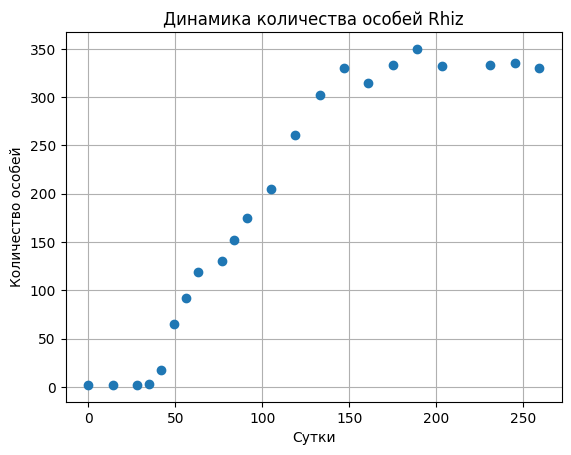

In [34]:
plt.plot(x_days, y_rhiz, 'o')
plt.title('Динамика количества особей Rhiz')
plt.xlabel('Сутки')
plt.ylabel('Количество особей')
plt.grid()
pass

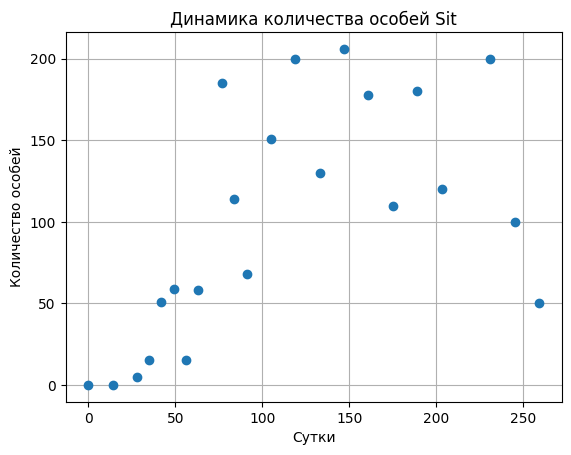

In [35]:
plt.plot(x_days, y_sit, 'o')
plt.title('Динамика количества особей Sit')
plt.xlabel('Сутки')
plt.ylabel('Количество особей')
plt.grid()
pass

Начальные коэффициенты для Rhiz: $a = 350, b = 1, c = -0.1$, подобраны по точке $\sim(180, 350)$

Начальные коэффициенты для Sit: $a = 200, b = 1, c = -0.1$, подобраны по точке $\sim(230, 200)$

С помощью функции `curve_fit` модуля `scipy.optimize` подберем коэффициенты:

In [36]:
popt_rhiz, pcov_rhiz = optimize.curve_fit(logistic, x_days, y_rhiz, [350, 1, -0.1])
popt_sit, pcov_sit = optimize.curve_fit(logistic, x_days, y_sit, [200, 1, -0.1])

#### Изображение данных

Доступные нам данные не являются непрерывными, поэтому мы будем отрисовывать их в виде точек.

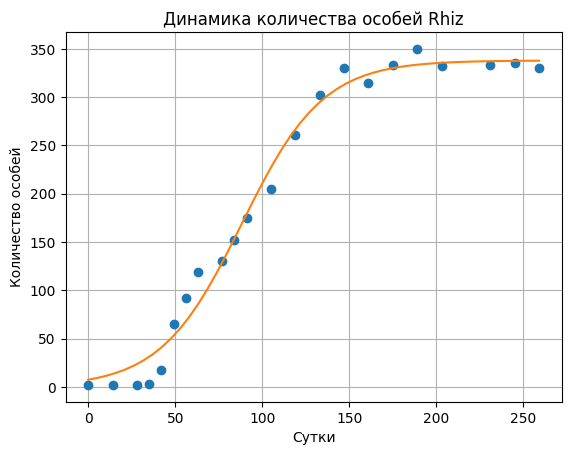

In [37]:
plt.plot(x_days, y_rhiz, 'o')
plt.plot(x_days_test, logistic(x_days_test, *popt_rhiz))
plt.title('Динамика количества особей Rhiz')
plt.xlabel('Сутки')
plt.ylabel('Количество особей')
plt.grid()

pass

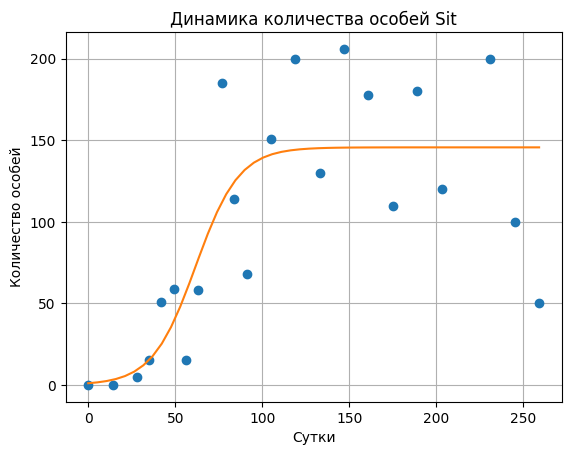

In [38]:
plt.plot(x_days, y_sit, 'o')
plt.plot(x_days_test, logistic(x_days_test, *popt_sit))
plt.title('Динамика количества особей Sit')
plt.xlabel('Сутки')
plt.ylabel('Количество особей')
plt.grid()
pass

#### Сравнение решения с эталонным

Решение, приведенное в статье, имеет следующие коэффициенты:

$a = 338, b = 87, c = 0.05$ для Rhiz;\
$a = 200, b = 257, c = 0.1$ для Sit;

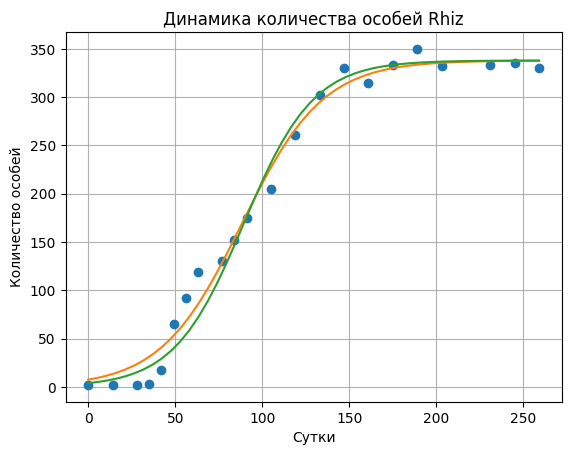

In [39]:
plt.plot(x_days, y_rhiz, 'o')
plt.plot(x_days_test, logistic(x_days_test, *popt_rhiz))
plt.plot(x_days_test, logistic(x_days_test, *[338, 87, 0.05]))
plt.title('Динамика количества особей Rhiz')
plt.xlabel('Сутки')
plt.ylabel('Количество особей')
plt.grid()

pass

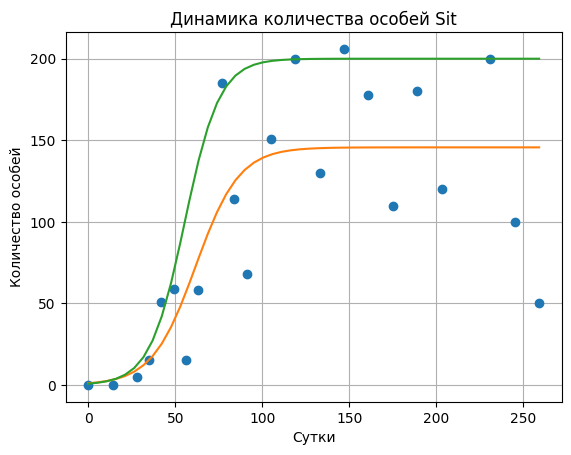

In [40]:
plt.plot(x_days, y_sit, 'o')
plt.plot(x_days_test, logistic(x_days_test, *popt_sit))
plt.plot(x_days_test, logistic(x_days_test, *[200, 257, 0.1]))
plt.title('Динамика количества особей Sit')
plt.xlabel('Сутки')
plt.ylabel('Количество особей')
plt.grid()

pass

#### Вывод

- Отличие нашего решение от эталонного несущественно в случае с Rhiz - во многом благодаря низкому разбросу в данных относительно роста значения по оси абсцисс.

- Решение заметно отклоняется от эталонного в случае с Sit - это как раз обуславливается высоким разбросом, но аппроксимация, полученная с помощью нелинейного метода наименьших квадратов в целом корректно отражает тренд.

- Отклонение может быть больше или меньше - в том числе оно зависит от начальных коэффициентов для подгона кривой.

- Таким образом, мы можем сказать, что метод нелинейных наименьших квадратов является эффективным и надежным методом для аппроксимации и отражения динамики в изменении данных.